# 🎮 Game Recommendation System

## 📌 Project Overview
This project builds a **game recommendation system** based on game attributes.

- **Dataset Source**: [Hugging Face Dataset](https://huggingface.co/datasets/wiliamlee/games_after_1_years)
- **Goal**: Build a recommendation system where a user uploads an image of a game, and the system suggests similar games.


## 📊 Dataset Description
- **Purpose**: <span style="color:green">This dataset is collected to analyze game trends and help users discover similar games.</span>
- **Types of Data**:
  - 🎮 Game metadata: **Title, Price, Genres, Platforms, Publishers**
  - 🖼️ Image links
  - ⭐ User reviews & ratings


In [1]:
!pip install scikit-learn

In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import requests
from io import BytesIO

In [3]:
# Load dataset from Hugging Face
ds = load_dataset("wiliamlee/games_after_1_years")


In [4]:
# Convert dataset to Pandas DataFrame
df = pd.DataFrame(ds["train"])  # Assuming 'train' is the correct split

In [5]:
# Display raw data samples
df.sample(5)

,AppID,name,required_age,price,dlc_count,detailed_description,about_the_game,short_description,header_image,website,...,pct_pos_recent,num_reviews_recent,owners,average_forever,average_2weeks,median_forever,median_2weeks,num_reviews_total,positive,negative
8014,2471150,Arthur's Teacher Trouble,0,9.99,0,Explore and share Marc Brown’s classic 'Arthur...,Explore and share Marc Brown’s classic 'Arthur...,Explore Marc Brown's 'Arthur’s Teacher Trouble...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://wanderfulstorybooks.com/livingbooks_ar...,...,-1,-1,"0 .. 20,000",0.0,0.0,0.0,0.0,2.0,2.0,0.0
18807,260210,Assassin’s Creed® Liberation HD,17,4.99,0,"Introducing Assassin’s Creed® Liberation HD, t...","Introducing Assassin’s Creed® Liberation HD, t...","Introducing Assassin’s Creed® Liberation HD, t...",https://shared.akamai.steamstatic.com/store_it...,http://www.assassinscreed.com/liberationhd,...,57,19,None,NaN,NaN,NaN,NaN,2789.0,1482.0,1307.0
4649,2313600,Shot Supreme,0,3.99,0,Shot Supreme is an arcade basketball game insp...,Shot Supreme is an arcade basketball game insp...,"Sink baskets to score points, complete mission...",https://cdn.akamai.steamstatic.com/steam/apps/...,https://brightworm.com,...,-1,-1,"0 .. 20,000",0.0,0.0,0.0,0.0,15.0,13.0,2.0
17690,790820,Valkyria Chronicles 4 Complete Edition,0,49.99,0,Complete Edition Includes All DLC Squad E to t...,A Continent Engulfed in the Bitter Flames of W...,A Continent Engulfed in the Bitter Flames of W...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://valkyria.sega.com,...,94,36,None,NaN,NaN,NaN,NaN,6307.0,5506.0,801.0
2944,1918880,Tales of Autumn,0,9.99,0,Creatures Befriend and tame wild creatures and...,Creatures Befriend and tame wild creatures and...,A wild farming RPG with an emphasis on animals...,https://shared.akamai.steamstatic.com/store_it...,https://www.talesofautumn.com/,...,-1,-1,"0 .. 20,000",0.0,0.0,0.0,0.0,33.0,33.0,0.0


"""
##  General Information about the Dataset
"""

In [6]:
# Display general dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21980 entries, 0 to 21979
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AppID                 21980 non-null  int64  
 1   name                  21980 non-null  object 
 2   required_age          21980 non-null  int64  
 3   price                 21980 non-null  float64
 4   dlc_count             21980 non-null  int64  
 5   detailed_description  20514 non-null  object 
 6   about_the_game        20502 non-null  object 
 7   short_description     20527 non-null  object 
 8   header_image          21980 non-null  object 
 9   website               9900 non-null   object 
 10  support_url           10617 non-null  object 
 11  support_email         17062 non-null  object 
 12  windows               21980 non-null  bool   
 13  mac                   21980 non-null  bool   
 14  linux                 21980 non-null  bool   
 15  notes              

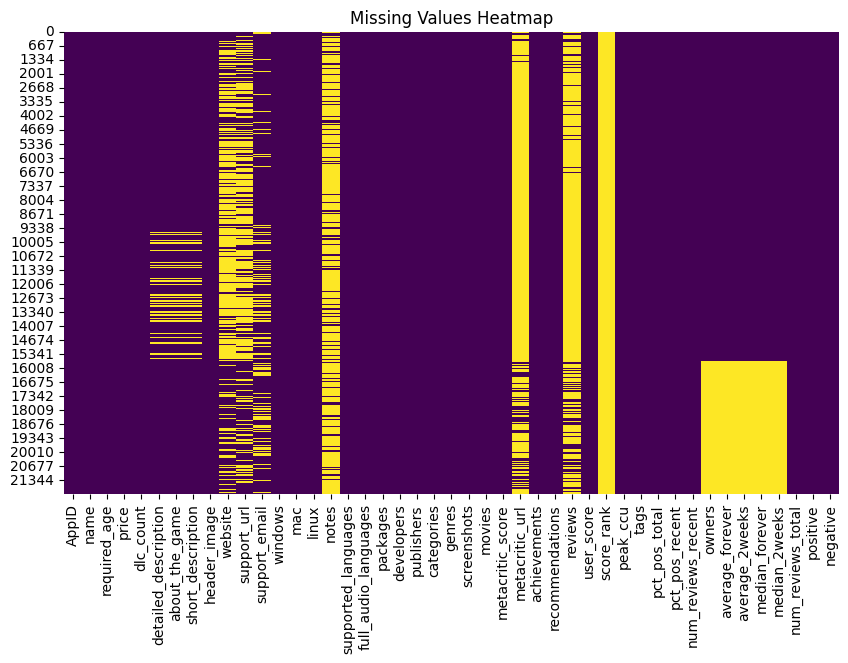

In [7]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

## ⚙️ Data Preprocessing
- **Step 1:** Remove missing values
- **Step 2:** Encode categorical variables
- **Step 3:** Normalize numerical columns

In [14]:
# Selecting important columns
important_columns = ["AppID", "name", "required_age", "price", "detailed_description", "header_image", "windows", "mac", "linux", "supported_languages", "categories", "genres", "publishers", "tags"]
df_cleaned = df[important_columns].dropna()

# Ensure dataset size is exactly 5000 rows
df_cleaned = df_cleaned.sample(n=5000, random_state=42)

# Select only the first 5000 rows that have all important columns filled
df_cleaned = df_cleaned[:5000]

# Ensure the dataset size is exactly 5000 rows
df_cleaned = df_cleaned.iloc[:5000]


In [15]:
# Label Encoding for categorical features
label_encoders = {}
for col in ["genres", "categories", "publishers", "tags"]:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

In [16]:
# Normalize the numerical features
scaler = StandardScaler()
df_cleaned[["price"]] = scaler.fit_transform(df_cleaned[["price"]])

In [17]:
# Save cleaned dataset
df_cleaned.iloc[:5000].to_csv("cleaned_games.csv", index=False)

##  Visualizations & Statistics After Preprocessing

In [18]:
# Display sample of cleaned dataset
import IPython.display as display
print("Cleaned Data Samples:")
display.display(df_cleaned.head())


Cleaned Data Samples:


,AppID,name,required_age,price,detailed_description,header_image,windows,mac,linux,supported_languages,categories,genres,publishers,tags
20268,1730680,Klonoa Phantasy Reverie Series,0,2.036855,KLONOA is a 3D side-scrolling action game seri...,https://shared.akamai.steamstatic.com/store_it...,True,False,False,"['English', 'French', 'Italian', 'German', 'Sp...",366,65,346,686
14062,2238980,Hacker's Restart,0,-0.328342,Hacker's Restart is a game about you and your ...,https://cdn.akamai.steamstatic.com/steam/apps/...,True,True,True,['English'],192,589,1591,0
6078,2404900,Cursed House 12,0,0.009543,"The house, which was once majestic, has now be...",https://shared.akamai.steamstatic.com/store_it...,True,False,False,['English'],192,521,1745,2342
1604,2236590,Psionic Awake,0,-0.497285,JOIN OUR DISCORD Discord: About the Game In th...,https://shared.akamai.steamstatic.com/store_it...,True,False,False,"['English', 'Simplified Chinese', 'Traditional...",1027,79,1457,14
21387,115110,Stacking,0,0.009543,"From Tim Schafer’s Double Fine Productions, ex...",https://cdn.akamai.steamstatic.com/steam/apps/...,True,True,True,"['English', 'German', 'French', 'Italian', 'Sp...",887,398,869,635


In [19]:
# Separate numerical and categorical columns
numerical_cols = ["AppID", "required_age", "price", "tags"]
categorical_cols = ["name", "detailed_description", "header_image", "windows", 
                    "mac", "linux", "supported_languages", "categories", "genres", "publishers"]


In [20]:
# Summary for numerical columns
print("\n📊 Numerical Column Summary:")
print(df_cleaned[numerical_cols].describe())



📊 Numerical Column Summary:
              AppID  required_age         price         tags
count  5.000000e+03   5000.000000  5.000000e+03  5000.000000
mean   1.792363e+06      0.637000  7.958079e-17  1497.532600
std    8.033340e+05      3.189556  1.000100e+00  1272.998993
min    6.000000e+01      0.000000 -6.655520e-01     0.000000
25%    1.179468e+06      0.000000 -5.310737e-01   120.750000
50%    2.173820e+06      0.000000 -3.283425e-01  1369.500000
75%    2.408120e+06      0.000000  2.798511e-01  2619.250000
max    2.923300e+06     21.000000  1.284918e+01  3869.000000


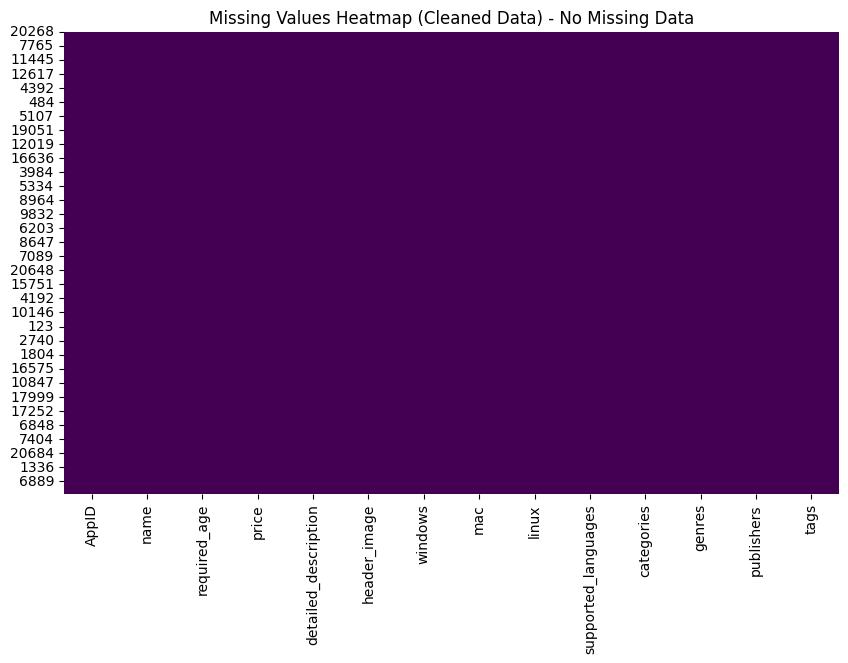

In [21]:
# Visualizing missing values in cleaned dataset
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Cleaned Data) - No Missing Data")
plt.show()

In [22]:
# Most expensive game
most_expensive_game = df_cleaned.loc[df_cleaned["price"].idxmax(), ["name", "price"]]
print("\n💰 Most Expensive Game:")
print(most_expensive_game)


💰 Most Expensive Game:
name     3D PUZZLE - Medieval Inn
price                   12.849185
Name: 14286, dtype: object


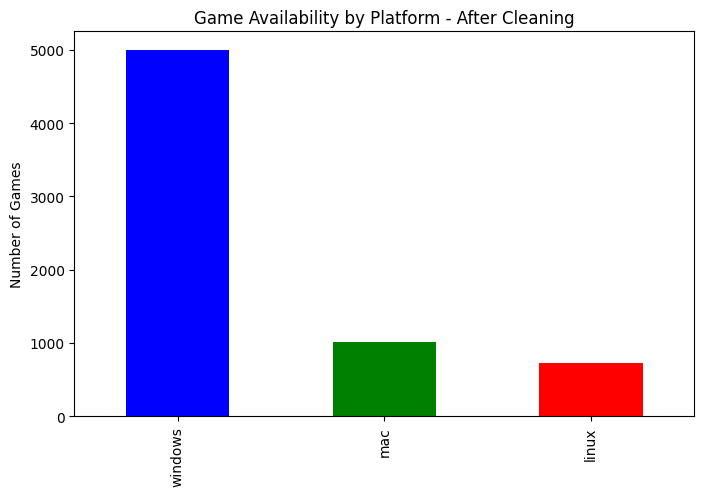

In [23]:
# Most supported platform
plt.figure(figsize=(8, 5))
df_cleaned[['windows', 'mac', 'linux']].sum().plot(kind='bar', color=["blue", "green", "red"])
plt.title("Game Availability by Platform - After Cleaning")
plt.ylabel("Number of Games")
plt.show()